## VOXPOPULI DATA

In [4]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  
from analysis import extract_pos_tag_scores, extract_freq_bucket_scores
from preprocessing import normalize_text, load_file
from analysis import calculate_wer_per_sentence, get_knn_gain_outliers, wer_summary
from better_by import (
    load_pickle, classify_sentences,
    extract_pos, extract_entities, plot_distribution
)
import pandas as pd
import matplotlib.pyplot as plt 
from plotting import plot_wer_distribution, plot_knn_gain_scatter


## POS - BUCKET ANALYSE 

In [6]:
html_path = "/Users/sedatgunay/Desktop/compare-mt-2/voxpopuli/comparemt_output_vox_pos/index.html"

print("POS LABEL TAGGING SCORES – VOXPOPULI")
df_voxpopuli_pos = extract_pos_tag_scores(html_path)
display(df_voxpopuli_pos)

POS LABEL TAGGING SCORES – VOXPOPULI


,Label,kNN-MT (sys1),Vanilla (sys2),Difference (sys1 - sys2)
0,ADJ,0.9233,0.9062,0.0171
1,NOUN,0.8708,0.8365,0.0343
2,PROPN,0.7594,0.7024,0.0570
3,VERB,0.9187,0.9027,0.0160
4,ADV,0.9022,0.8949,0.0073
5,NUM,0.5885,0.5216,0.0669
6,DET,0.9262,0.9225,0.0037
7,PRON,0.8903,0.8742,0.0161
8,ADP,0.9442,0.9392,0.0050
9,CCONJ,0.8860,0.8542,0.0318


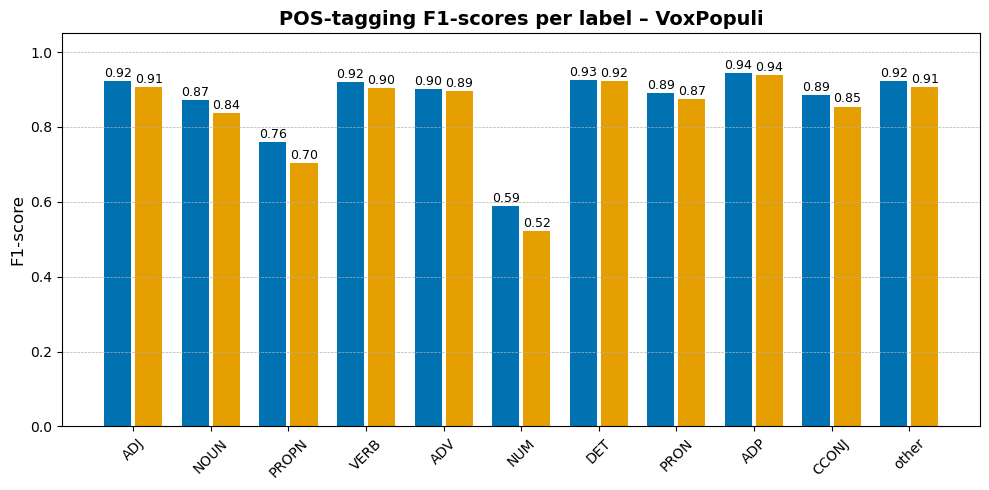

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Kleurenblindvriendelijke kleuren
colors = ["#0072B2", "#E69F00"]

labels = df_voxpopuli_pos["Label"]
x = range(len(labels))
width = 0.35
gap = 0.05

# Plot beide systemen 
bars1 = ax.bar([i - gap/2 for i in x], df_voxpopuli_pos["kNN-MT (sys1)"], width, label="kNN-MT", color=colors[0])
bars2 = ax.bar([i + width + gap/2 for i in x], df_voxpopuli_pos["Vanilla (sys2)"], width, label="Vanilla", color=colors[1])

# Waarden bovenop de balken
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Titels en labels
ax.set_ylabel("F1-score", fontsize=12)
ax.set_title("POS-tagging F1-scores per label – VoxPopuli", fontsize=14, fontweight='bold')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45, fontsize=10)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis="y", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("pos_f1_voxpopuli.png", dpi=300, bbox_inches="tight")
plt.show()

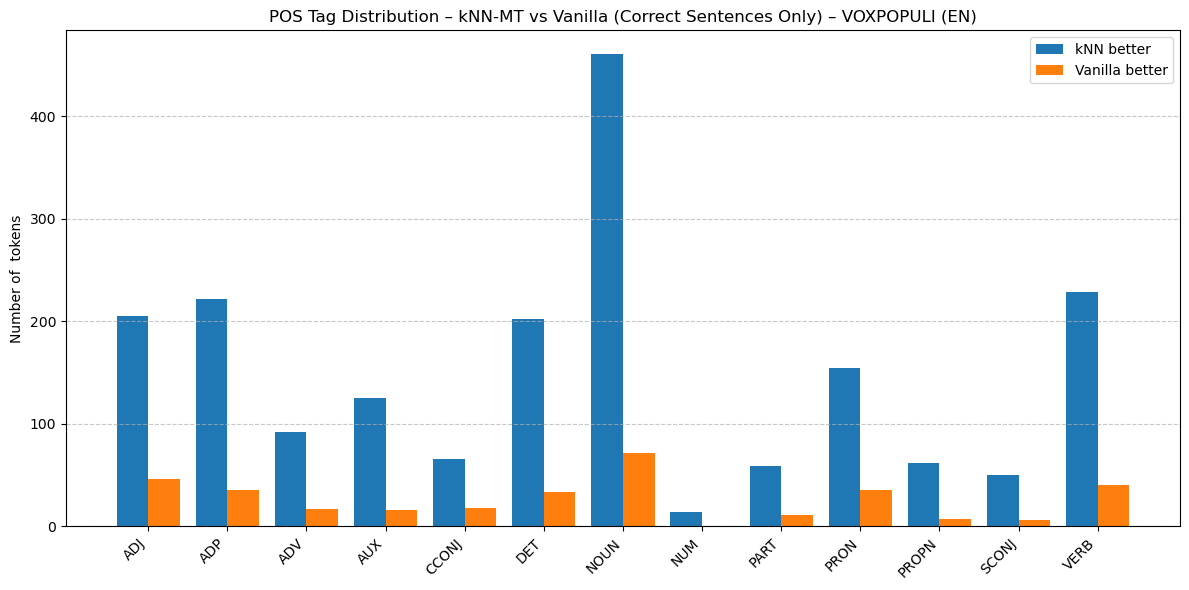

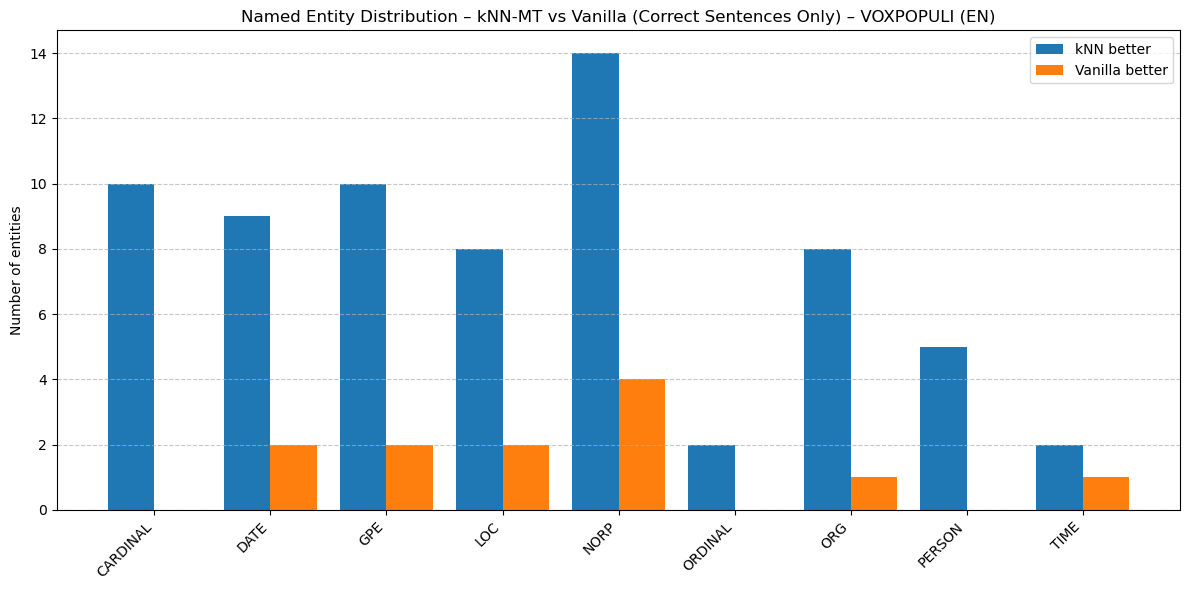

In [8]:
base_path = "/Users/sedatgunay/Desktop/ASR_KNN/dataset data (+outputs)/voxpopuli"
lang = "en"  

# Load data
ref = load_pickle(os.path.join(base_path, "test_ref_texts.pkl"))
knn = load_pickle(os.path.join(base_path, "test_knn_texts.pkl"))
van = load_pickle(os.path.join(base_path, "test_van_texts.pkl"))


ref = [normalize_text(line) for line in ref]
knn  = [normalize_text(line) for line in knn]
van = [normalize_text(line) for line in van]

# Sort better by sentences on systems 
better_knn, better_van = classify_sentences(ref, knn, van)

# POS-tag analysis
pos_knn = extract_pos(better_knn, lang=lang)
pos_van = extract_pos(better_van, lang=lang)
all_pos = sorted(set(pos_knn.keys()).union(pos_van.keys()))

plot_distribution(
    all_pos,
    [pos_knn.get(p, 0) for p in all_pos],
    [pos_van.get(p, 0) for p in all_pos],
    title=f"POS Tag Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – VOXPOPULI ({lang.upper()})",
    ylabel="Number of  tokens"
)

# Entity-analyse
ent_knn = extract_entities(better_knn, lang=lang)
ent_van = extract_entities(better_van, lang=lang)
all_ents = sorted(set(ent_knn.keys()).union(ent_van.keys()))

plot_distribution(
    all_ents,
    [ent_knn.get(e, 0) for e in all_ents],
    [ent_van.get(e, 0) for e in all_ents],
    title=f"Named Entity Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – VOXPOPULI ({lang.upper()})",
    ylabel="Number of entities"
)

## WER ANALYSE

In [9]:
# wer analyses
wer_knn = calculate_wer_per_sentence(ref,knn)
wer_van = calculate_wer_per_sentence(ref,van)

# print means 
print("Mean WER (kNN):", wer_summary(ref,knn)["wer"])
print("Mean WER (van):", wer_summary(ref,van)["wer"])


# Vind zinnen waar kNN significant beter was
gain_outliers = get_knn_gain_outliers(ref, knn, van, threshold=0.2)
gain_indices = [entry[0] for entry in gain_outliers]

# gain_outliers

Mean WER (kNN): 0.11673345559102538
Mean WER (van): 0.13507210939799408


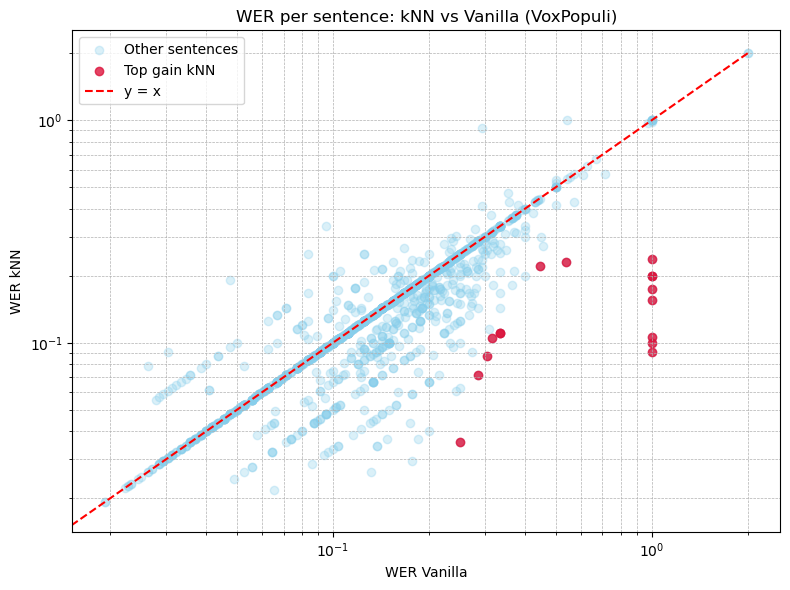

In [10]:
plot_knn_gain_scatter(
    wer_knn, wer_van, gain_indices,
    domain_label="VoxPopuli",
    log_scale=True
)

In [11]:
df_gain = pd.DataFrame(gain_outliers, columns=[
    "Index", "ref", "vanilla", "knn", "wer_vanilla", "wer_knn", "wer_gain_knn"
])

# Sorteer op grootste winst, optioneel
df_gain = df_gain.sort_values(by="wer_gain_knn", ascending=False).reset_index(drop=True)

# Bekijk de eerste rijen
display(df_gain)  

,Index,ref,vanilla,knn,wer_vanilla,wer_knn,wer_gain_knn
0,263,2008. in line with the current debate on ways ...,thank you.,2008. in line with the current debate on the w...,1.000000,0.090909,0.909091
1,135,the commitment to democratic reform of ukraine...,thank you very much.,that the commitment to democratic reform of uk...,1.000000,0.100000,0.900000
2,78,on the margins of the current transatlantic ne...,thank you.,on the margins of the current transatlantic ne...,1.000000,0.106383,0.893617
3,251,"mr president, in the committee on budgets, we ...",thank you.,"in the committee on budgets, we voted on more ...",1.000000,0.156250,0.843750
4,573,"i appreciate very much what you said, but can ...",okay.,"i appreciate very much what you said, but can ...",1.000000,0.175000,0.825000
5,248,"subject to the codecision procedure and, as we...",thank you.,"and all subjects to the co-decision procedure,...",1.000000,0.200000,0.800000
6,1641,i would like to ask you to support this text.,thank you.,i would like to ask you to support these texts.,1.000000,0.200000,0.800000
7,1121,only a common eu solution can realistically pr...,thank you very much.,the ecomon eu solution can realistically preve...,1.000000,0.238095,0.761905
8,1812,the problem is complex.,is complex.,the problem is complex.,0.500000,0.000000,0.500000
9,1798,this relationship.,this relationship...,this relationship.,0.500000,0.000000,0.500000


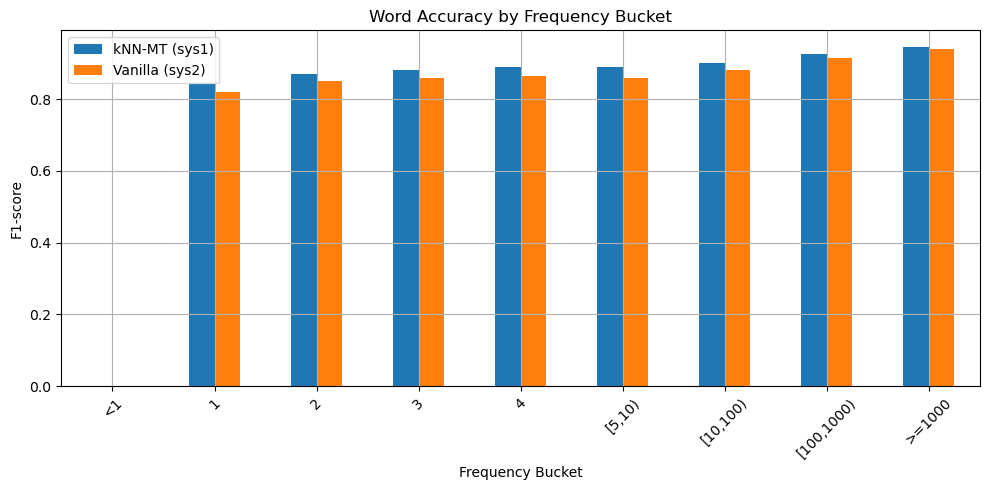

,Frequency Bucket,kNN-MT (sys1),Vanilla (sys2),Difference (sys1 - sys2)
0,<1,0.0000,0.0000,0.0000
1,1,0.8414,0.8203,0.0211
2,2,0.8690,0.8505,0.0185
3,3,0.8808,0.8598,0.0210
4,4,0.8889,0.8640,0.0249
5,"[5,10)",0.8885,0.8583,0.0302
6,"[10,100)",0.9020,0.8817,0.0203
7,"[100,1000)",0.9261,0.9157,0.0104
8,>=1000,0.9445,0.9383,0.0062


In [12]:

html_path = "/Users/sedatgunay/Desktop/compare-mt-2/voxpopuli/comparemt_output_freq/index.html"

df_commonvoice_pos_TEST = extract_freq_bucket_scores(html_path)
display(df_commonvoice_pos_TEST)